# Dataset and Split

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris


data = load_iris()

X,Y = data.data, data.target

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,stratify=Y ,random_state=42)

df_train = pd.concat([pd.DataFrame(x_train, columns=data.feature_names),pd.DataFrame(y_train, columns=['class'])],axis=1)
df_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,4.4,2.9,1.4,0.2,0
1,4.9,2.5,4.5,1.7,2
2,6.8,2.8,4.8,1.4,1
3,4.9,3.1,1.5,0.1,0
4,5.5,2.5,4.0,1.3,1
...,...,...,...,...,...
115,4.9,3.6,1.4,0.1,0
116,4.7,3.2,1.3,0.2,0
117,5.5,4.2,1.4,0.2,0
118,6.9,3.1,4.9,1.5,1


# Data vizualization

## Scatter Matrix

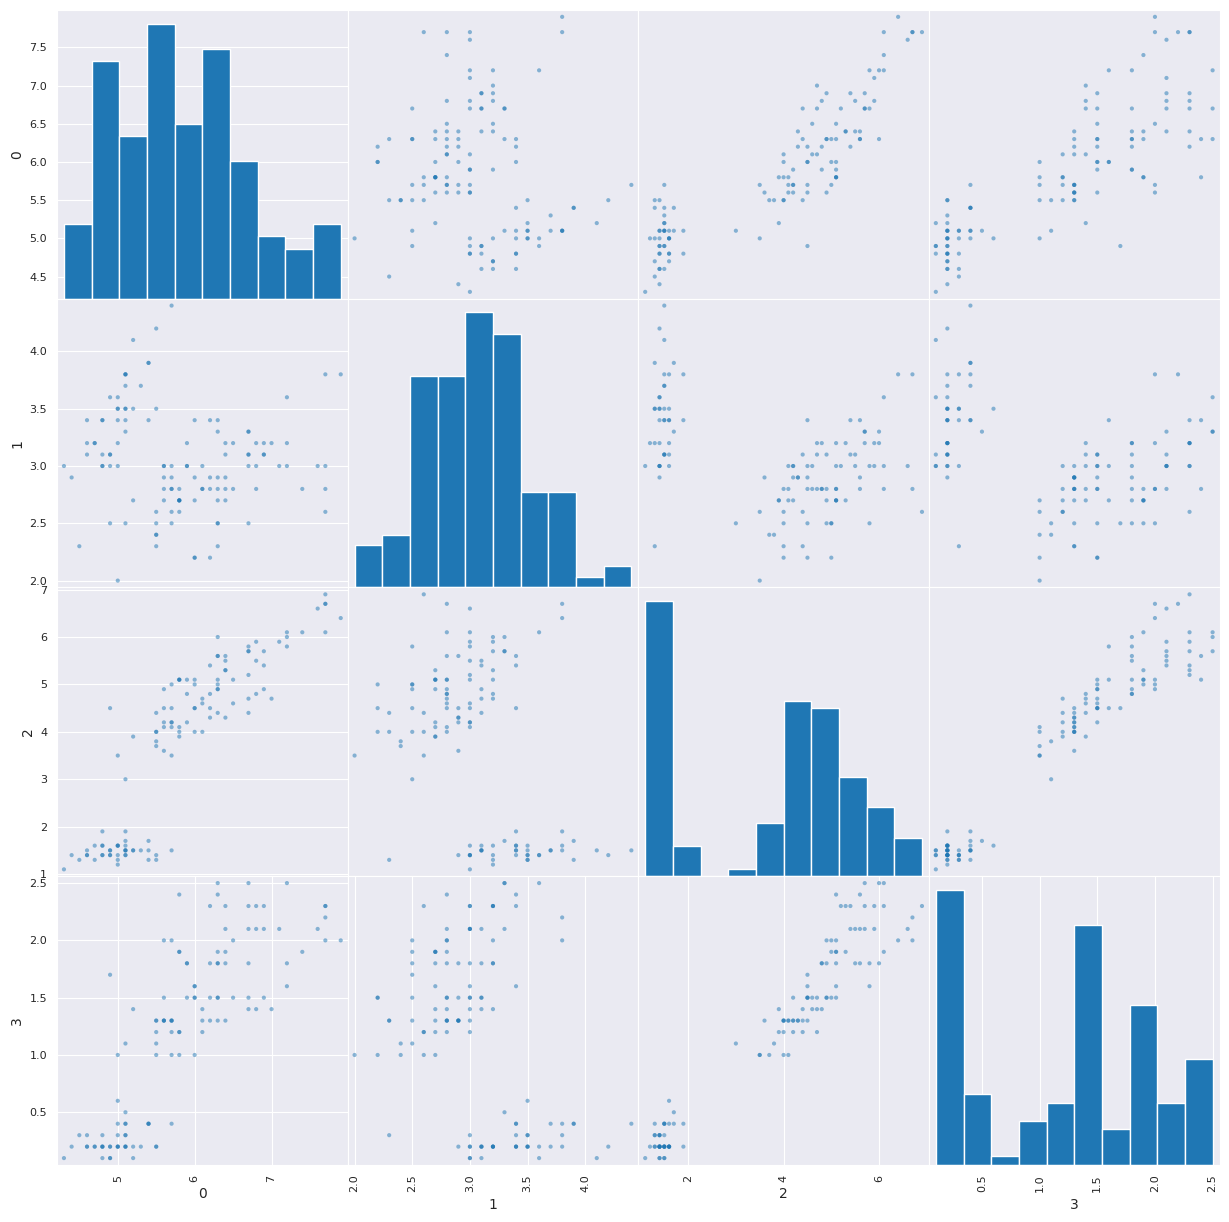

In [2]:
from pandas.plotting import scatter_matrix

df_x_train = pd.DataFrame(x_train)
scatter_matrix(df_x_train, figsize=(15,15))

plt.show()

## Correlation Matrix

In [ ]:
names = data.feature_names
corr_mtx = (df_x_train).corr(method='pearson')
plt.matshow(corr_mtx, cmap="jet")
plt.colorbar()

plt.xticks(range(len(names)), names, rotation=90)
plt.yticks(range(len(names)), names)
plt.grid(False)
plt.show()

corr_mtx

# Metric function

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

def metric(preds, probs, true_labels):

    classes = np.unique(true_labels)
    true_labels_bin = label_binarize(true_labels, classes=classes)

    #Metrics
    cr = classification_report(true_labels, preds)
    cf_mtx = confusion_matrix(true_labels, preds)


    auc_scores = []
    for c in classes:
        auc_score = roc_auc_score(true_labels_bin[:, c], probs[:, c])
        auc_scores.append(auc_score)

    roc_area_macro = np.mean(auc_scores)

    #Ploting
    fig, (ax_cfmtx, ax_roc) = plt.subplots(1,2, figsize=(15,5))

    #Roc curves
    ax_roc.set_title(f'Krzywe ROC (One-vs-Rest)\nMacro AUC: {roc_area_macro:.4f}', fontsize=14)
    ax_roc.plot([0, 1], [0, 1], 'k--', label='Losowy (AUC = 0.5)', alpha=0.6)
    for c in classes:
        fpr, tpr, _ = roc_curve(true_labels_bin[:, c], probs[:, c])
        ax_roc.plot(fpr, tpr,label=f'Klasa {classes[c]} (AUC: {auc_scores[c]:.2f})')

    ax_roc.set_xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
    ax_roc.set_ylabel('Czułość (TPR)')
    ax_roc.legend(loc="lower right", fontsize=9)
    ax_roc.grid(linestyle='--', alpha=0.5)

    #Confusion matrix
    ax_cfmtx.grid(False)
    ax_cfmtx = ConfusionMatrixDisplay(confusion_matrix=cf_mtx).plot(ax = ax_cfmtx, cmap="grey")

    print(cr)
    print(f'{roc_area_macro=}')

classes = np.unique(y_train)
metric(y_train, label_binarize(y_train, classes=classes), y_train)

# Optimize, train and judge

In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import time

def selected_features(selector):
    global names

    mask = selector.get_support()
    selected_names = np.array(names)[mask]
    return list(selected_names)


def optimize_train_and_judge(scaler_class, model_class, objective_fn, trails=100):
    global x_train, y_train, x_test, y_test

    study = optuna.create_study(direction="maximize")

    start = time.time()
    study.optimize(objective_fn, n_trials=trails, show_progress_bar=True)
    stop = time.time()


    pipe = Pipeline([('scaler',scaler_class()),('features_selector', RFE(estimator=DecisionTreeClassifier())) ,('classifier', model_class())])
    pipe.set_params(**study.best_params)
    pipe.fit(x_train, y_train)

    ## Metrics
    preds = pipe.predict(x_test)
    probs = pipe.predict_proba(x_test)
    metric(preds, probs, y_test)

    selector = pipe.named_steps['features_selector']
    names_selected = selected_features(selector)
    features_shape = [x_test.shape[0], len(names_selected)]
    print(f"Selected features: {names_selected}")
    print(f"Optimize time: {stop-start}")

    return pipe

# Scalers

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

class RoubustMinMaxScaler():
    def __init__(self, q_r:tuple[int] = (25, 75)):
        self.q_r = (q_r[0]/100, q_r[1]/100)

    def fit(self, X):

        [qa, qb] = np.quantile(X, q=self.q_r, axis=0)
        self.qa = qa
        self.qb = qb

        return self

    def transform(self, X):
        x_std = (X - self.qa) / (self.qb - self.qa)
        return x_std